In [69]:
import os, time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from scipy.signal import resample

In [60]:
SAMPLE_POINTS = 50
INPUT_PARAMETERS = 3

SCRIPT_DIR = os.path.abspath('') #os.path.dirname(__file__); workaround for jupyter notebook

DATA_PATH = os.path.join(SCRIPT_DIR, "data")

In [65]:
data: list[tuple[str, list[tuple]]] = []

In [62]:
def get_data(path: str, data_list: list) -> None:
  for *_, files in os.walk(path):
    if len(files) == 0:
      continue

    for file_name in files:
      if not file_name.endswith(".csv"):
        continue

      file_path = os.path.join(path, file_name)

      data = pd.read_csv(filepath_or_buffer=file_path, delimiter=",")

      points = data[["accelerometer_x", "accelerometer_y", "accelerometer_z"]]
      points = np.array(points, dtype=float)
      class_name = data["gesture"][0]

      scaler = StandardScaler()
      points = scaler.fit_transform(points)

      points_resampled = resample(points, SAMPLE_POINTS)

      data_list.append((class_name, points_resampled))

In [66]:
get_data(DATA_PATH, data)

In [67]:
print(data[0])

('TILT_LEFT', array([[ 3.57121289e-01, -1.46260638e-02,  3.44675113e-01],
       [-7.93082547e-02,  1.16479312e-01, -4.31973049e-01],
       [ 6.29642530e-02, -7.17675670e-02,  2.26172999e-01],
       [-1.50854800e-01, -6.12292618e-01,  6.02289689e-01],
       [-1.08517910e-02,  2.72463822e-01, -9.90160136e-03],
       [-2.19568840e-01,  2.86854617e-01, -2.86411690e-01],
       [-1.35203960e-01,  8.42227160e-02, -6.98526969e-01],
       [-5.97215128e-01, -1.30689023e+00,  7.53746265e-01],
       [ 3.08328419e-01,  7.79805127e-01, -4.89357393e-01],
       [-6.02717929e-01, -4.12284321e-01, -3.46645667e-01],
       [ 1.86682120e+00,  9.28831311e-01,  4.03607218e-02],
       [ 1.62669153e+00, -7.25663018e-01,  5.45092033e-01],
       [-6.43817086e-01,  1.26415765e+00, -3.69140261e-01],
       [ 2.26390309e-01, -3.49617220e-01,  2.64801524e-01],
       [ 3.58367091e-01,  2.51039236e-01, -1.05803267e+00],
       [ 7.74301713e-03, -6.93283051e-01,  3.12195532e-02],
       [-2.33234363e-01, -

In [70]:
# Prepare the data
labels = [sample[0] for sample in data]

print(set(labels))

encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)

print(set(labels_encoded))

y = to_categorical(labels_encoded)

print(len(y[0]))

sequences = [sample[1] for sample in data]
X = np.array(sequences)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


{'TILT_LEFT'}
{0}
1
(4, 50, 3) (1, 50, 3) (4, 1) (1, 1)


In [71]:
class NN:   

  def init(self, options: dict) -> None:
    self.model = Sequential()

    self.model.add(LSTM(options["lstm_neurons"], input_shape=(SAMPLE_POINTS, INPUT_PARAMETERS)))
    self.model.add(Dense(options["fully_connected_neurons"], activation=options["fully_connected_activation_function"]))
    if options["add_dropout"]:
      self.model.add(Dropout(options["dropout_rate"]))
    self.model.add(Dense(len(set(labels)), activation='softmax'))

    self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    self.reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=options["learn_rate"])
    self.stop_early = EarlyStopping(monitor='val_loss', patience=3)

  def train(self, X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray, options: dict) -> None:
    # Train the model
    self.history = self.model.fit(
      X_train,
      y_train,
      epochs=options["epochs"],
      batch_size=options["batch_size"],
      validation_data=(X_test, y_test),
      verbose=1,
      callbacks=[self.reduce_lr, self.stop_early]
    )

  def summarise(self) -> None:
    self.model.summary()

  def plot(self) -> None:
    loss = self.history.history['loss']
    val_loss = self.history.history['val_loss']
    accuracy = self.history.history['accuracy']
    val_accuracy = self.history.history['val_accuracy']

    fig = plt.figure(figsize=(15, 7))
    ax = plt.gca()

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

    ax.axhline(1, color='gray')

    plt.plot(accuracy, color='blue')
    plt.plot(val_accuracy, color='orange')
    plt.plot(loss, '--', color='blue', alpha=0.5)
    plt.plot(val_loss, '--', color='orange', alpha=0.5)

  def predict(self, X_test: np.ndarray, y_test: np.ndarray, labels_train: list[str]) -> int:
    # let the model make predictions for our training data
    t1 = time.time()
    y_predictions = self.model.predict(X_test)
    t2 = time.time()
    

    # to build a confusion matrix, we have to convert it to classifications
    # this can be done by using the argmax() function to set the probability to 1 and the rest to 0
    y_predictions = np.argmax(y_predictions, axis=1)

    y_test_labels = np.argmax(y_test, axis=1)

    # create and plot confusion matrix
    conf_matrix = confusion_matrix(y_test_labels, y_predictions)

    fig = plt.figure(figsize=(10, 10))

    ConfusionMatrixDisplay(conf_matrix, display_labels=set(labels_train)).plot(ax=plt.gca())

    plt.xticks(rotation=90, ha='center')
    
    return t2-t1

Epoch 1/10


/Users/micha/Projects/ITT/08_assignment/.venv/lib/python3.10/site-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


1/1 [==============================] - 3s 3s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/10
1/1 [==============================] - 0s 52ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/10
1/1 [==============================] - 0s 47ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/10
1/1 [==============================] - 0s 48ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 2.0000e-04
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                17408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                   

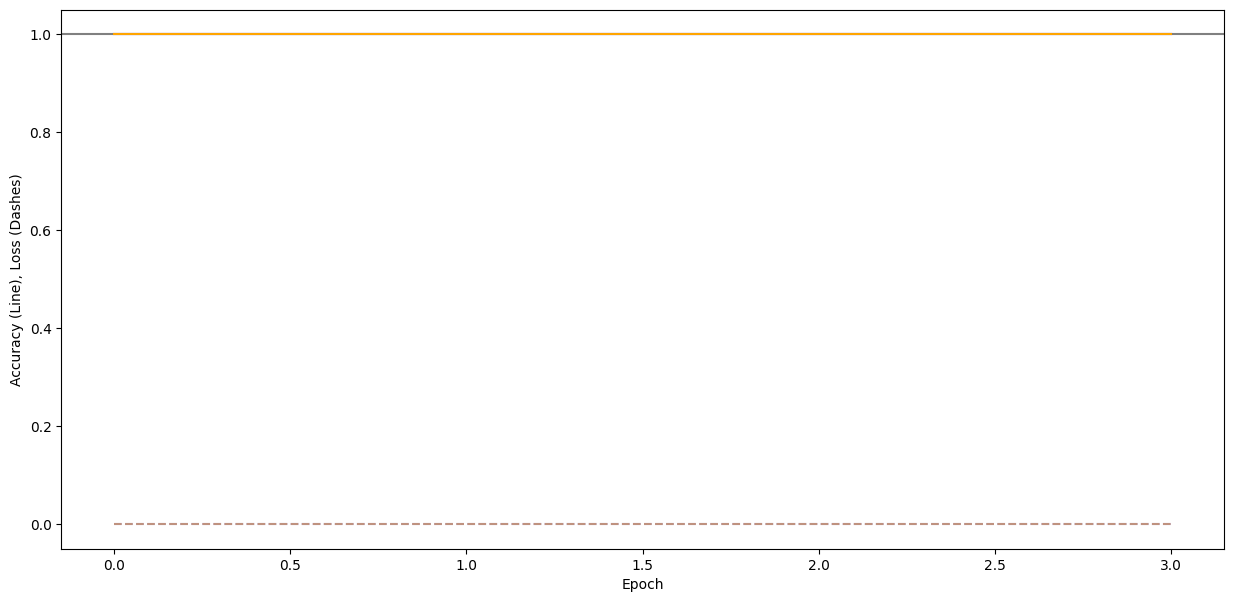

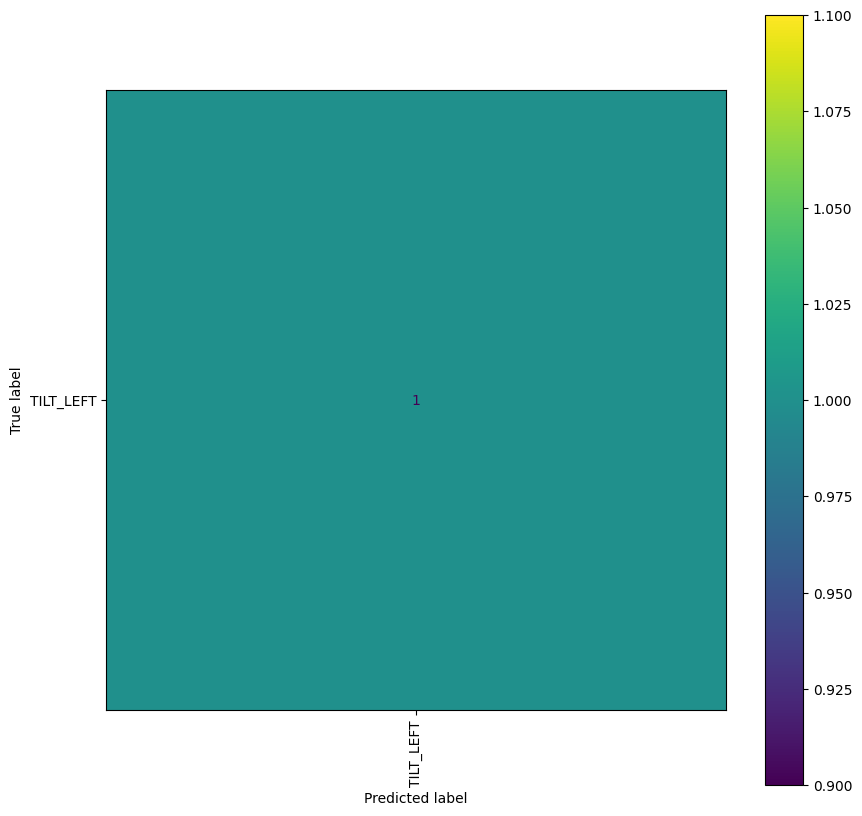

In [72]:
options = {
  "lstm_neurons": 64,
  "fully_connected_neurons": 32,
  "fully_connected_activation_function": "relu",
  "epochs": 10,
  "batch_size": 32,
  "learn_rate": 0.0001,
  "add_dropout": False,
  "dropout_rate": 0.2
}

nn = NN()
nn.init(options)
nn.train(X_train, y_train, X_test, y_test, options)
nn.summarise()
nn.plot()
time = nn.predict(X_test, y_test, labels)

In [ ]:
nn.model.save("lstm_model")